# Text Mining Project - Predicting Airbnb listing status using NLP models

# Project Structure
1. **Data Exploration**
2. **Translation**
3. **Data Exploration and Preprocessing (after translation)**
5. **Models using only Description and Host information**
   - TF-IDF (KNN, LR, RF)
   - Doc2Vec (KNN, LR, RF)
   - GloVe (KNN, LR, RF)
7. **Models combining Description, Host information and Reviews**
   - Description + Host (TF-IDF) + Reviews (embeddings)
   - Description + Host + Reviews (embeddings)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import re
from tqdm import tqdm
from wordcloud import WordCloud

import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect, LangDetectException
#from autocorrect import Speller
#import contractions

from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, confusion_matrix

from sentence_transformers import SentenceTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from keras.callbacks import EarlyStopping

import torch
from torch.autograd import Variable
import torch.nn.functional as F

import torchtext.vocab as vocab

import warnings
warnings.filterwarnings("ignore")

# 1. Data Exploration (before translation)

In [ ]:
# Training df
train_df = pd.read_excel("data/train.xlsx")
train_df

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0


In [ ]:
# Training reviews
train_reviews_df = pd.read_excel("data/train_reviews.xlsx")
train_reviews_df

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
...,...,...
361276,6248,The location was perfect. The apartment was ve...
361277,6248,Ana's place is exactly as described and even b...
361278,6248,A Ana foi muito atenciosa e preocupou se com o...
361279,6248,No wifi nor answer. <br/>The wifi can’t be con...


In [ ]:
# Test datasets
test_df = pd.read_excel("data/test.xlsx")
test_reviews_df = pd.read_excel("data/test_reviews.xlsx")

In [ ]:
# We have 6248 properties, with no missing values
# We have 361281 properties and 361279 comments, 2 missing values
print(f'Train info: {train_df.info()}')
print("-"*50)
print(f'Train reviews info: {train_reviews_df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        6248 non-null   int64 
 1   description  6248 non-null   object
 2   host_about   6248 non-null   object
 3   unlisted     6248 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.4+ KB
Train info: None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB
Train reviews info: None


In [ ]:
# We have 4245 properties with reviews
train_reviews_df.groupby('index')['comments'].nunique()

index
1        50
5        41
8       168
9        33
10       13
       ... 
6244    100
6245    130
6246     25
6247     25
6248    275
Name: comments, Length: 4245, dtype: int64

In [ ]:
# 2003 properties from the train_df don't have comments
print(f"Properties with no reviews: {train_df.shape[0]-train_reviews_df['index'].nunique()}")

Properties with no reviews: 2003


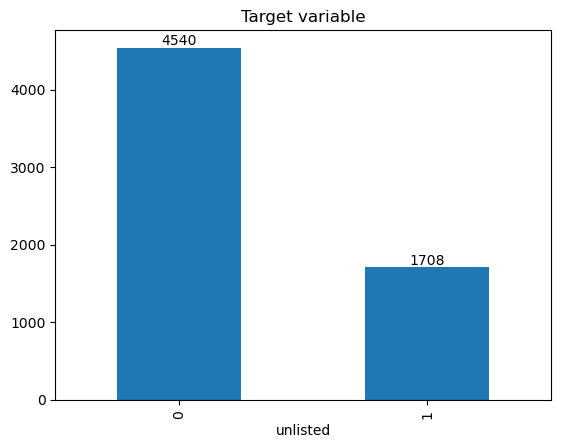

In [ ]:
# We have an imbalanced dataset, with a majority of the properties being listed
ax = train_df['unlisted'].value_counts().plot(kind='bar')
plt.title('Target variable')
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
# Average word count
print(f"Avg word count for description: {train_df['description'].apply(lambda x: len(str(x).split(' '))).mean()}")
print(f"Avg word count for host: {train_df['host_about'].apply(lambda x: len(str(x).split(' '))).mean()}")
print(f"Avg word count for reviews: {train_reviews_df['comments'].apply(lambda x: len(str(x).split(' '))).mean()}")

Avg word count for description: 132.86075544174136
Avg word count for host: 73.65300896286811
Avg word count for reviews: 47.97310680605955


### Word Clouds (before preprocessing)

In [ ]:
def plot_word_cloud(df, column):
    wordcloud = WordCloud(width=400, height=200, background_color="white").generate(' '.join(df[column]))
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'{column} Word Cloud')
    plt.show()

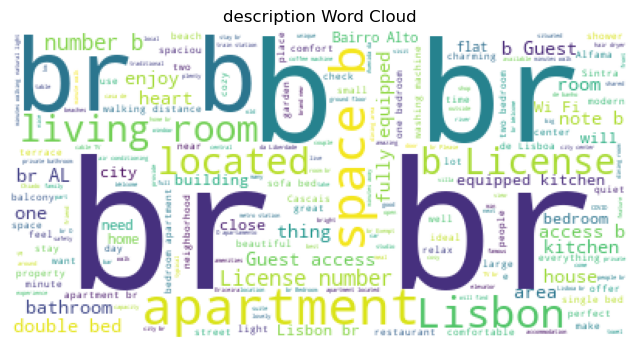

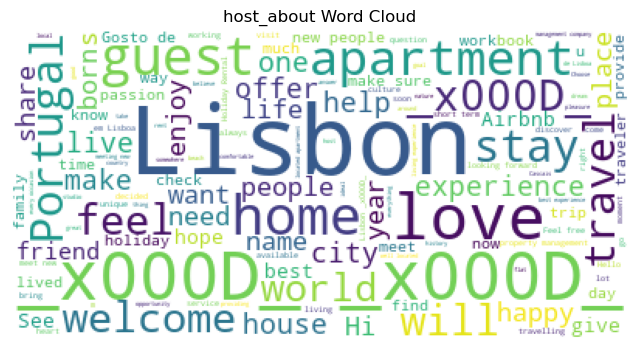

In [ ]:
plot_word_cloud(train_df, 'description')
plot_word_cloud(train_df, 'host_about')

### Quick preprocess to get the language count

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [ ]:
def quick_clean(text_list, lemmatize, stemmer):
    updates = []
    for text in tqdm(text_list):
        if isinstance(text, float):
            text = ''
        else:
            text = text.lower()
            text = re.sub("[^a-zA-Z]"," ", text)
            text = re.sub(r"<\/?[\w\s]*>|<.+[\W]>"," ", text)
            text = re.sub("_x000D_\n"," ", text)
            text = re.sub(r" x "," ", text)
            text = re.sub(r" br "," ", text)
            text = re.sub(r" b "," ", text)
            # Tokenize text
            tokens = word_tokenize(text)
            # Remove stopwords
            text = " ".join([word for word in text.split() if word not in stop_words])
            # Lemmatize
            if lemmatize:
                tokens = [lemma.lemmatize(word) for word in tokens]
            # Stemmer
            if stemmer:
                tokens = [stemmer.stem(word) for word in tokens]
            text = " ".join(tokens)

        updates.append(text)
    return updates

In [ ]:
clean_description = quick_clean(train_df['description'], lemmatize = True, stemmer = False)
clean_host = quick_clean(train_df['host_about'], lemmatize = True, stemmer = False)
clean_comments = quick_clean(train_reviews_df['comments'], lemmatize = True, stemmer = False)

train_df['clean_description'] = clean_description
train_df['clean_host_about'] = clean_host
train_reviews_df['clean_comments'] = clean_comments

100%|████████████████████████████████████████████████████████████████████████| 361281/361281 [01:51<00:00, 3242.20it/s]


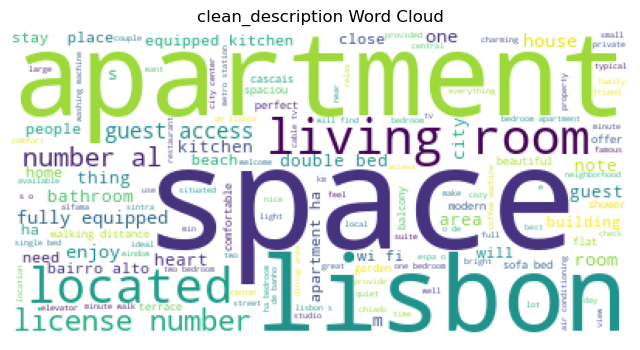

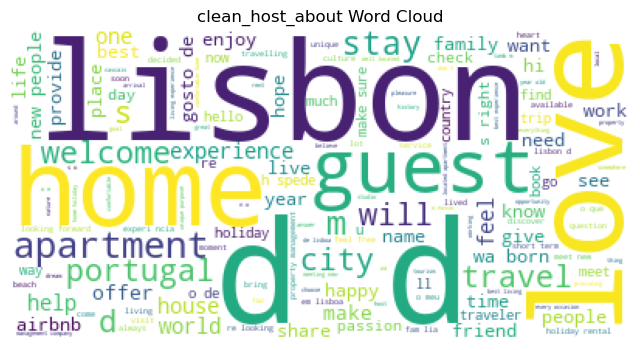

In [ ]:
plot_word_cloud(train_df, 'clean_description')
plot_word_cloud(train_df, 'clean_host_about')

In [ ]:
# !pip install langid

In [ ]:
import langid

def get_languages_num(df, column):
    # handle NaN values by replacing them with empty strings
    df_column = df[column].fillna('')
    # get the language id for each text
    ids_langid = df_column.apply(langid.classify)
    # get just the language label
    langs = ids_langid.apply(lambda tuple: tuple[0])
    # unique languages
    print(f"Number of tagged languages (estimated): {len(langs.unique())}")
    # percent of the total dataset in English, Portuguese, French, German, Spanish
    print(f"Data in English (estimated): {(sum(langs=='en')/len(langs))*100}%")
    print(f"Data in Portuguese (estimated): {(sum(langs=='pt')/len(langs))*100}%")
    print(f"Data in French (estimated): {(sum(langs=='fr')/len(langs))*100}%")
    print(f"Data in German (estimated): {(sum(langs=='de')/len(langs))*100}%")
    print(f"Data in Spanish (estimated): {(sum(langs=='es')/len(langs))*100}%")
    # convert our list of languages to a dataframe
    langs_df = pd.DataFrame(langs)
    # count the number of times we see each language
    langs_count = langs_df[column].value_counts(ascending=False)
    # Bar plot
    ax = langs_count.plot.bar(figsize=(10,8), fontsize=10)
    ax.set_title(column, fontsize=14)

Number of tagged languages (estimated): 12
Data in English (estimated): 82.95454545454545%
Data in Portuguese (estimated): 14.052496798975673%
Data in French (estimated): 1.296414852752881%
Data in German (estimated): 0.7522407170294494%
Data in Spanish (estimated): 0.5121638924455826%


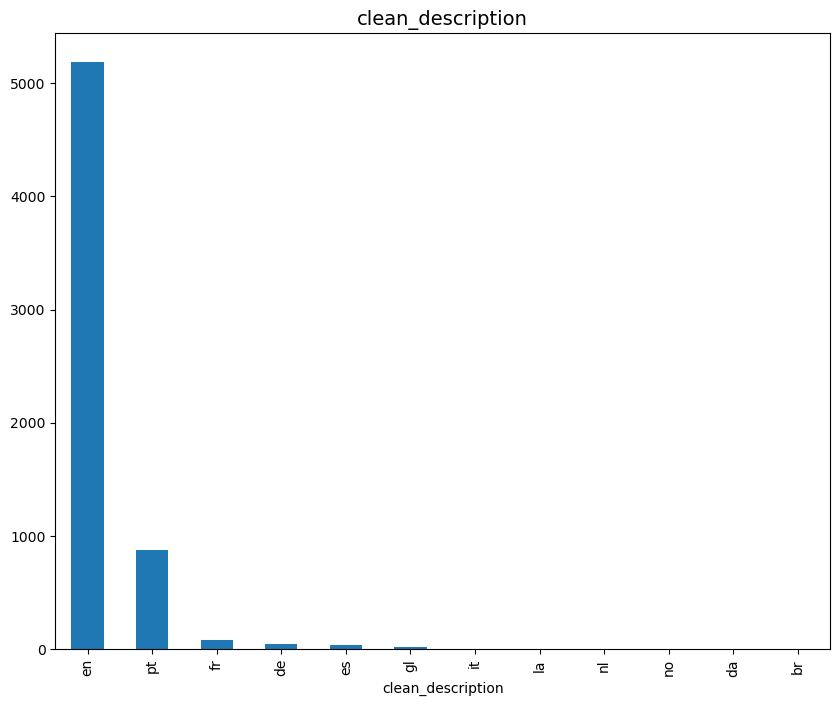

In [ ]:
get_languages_num(train_df, 'clean_description')

Number of tagged languages (estimated): 32
Data in English (estimated): 73.9596670934699%
Data in Portuguese (estimated): 18.613956466069144%
Data in French (estimated): 1.9046094750320102%
Data in German (estimated): 0.9122919334186941%
Data in Spanish (estimated): 1.792573623559539%


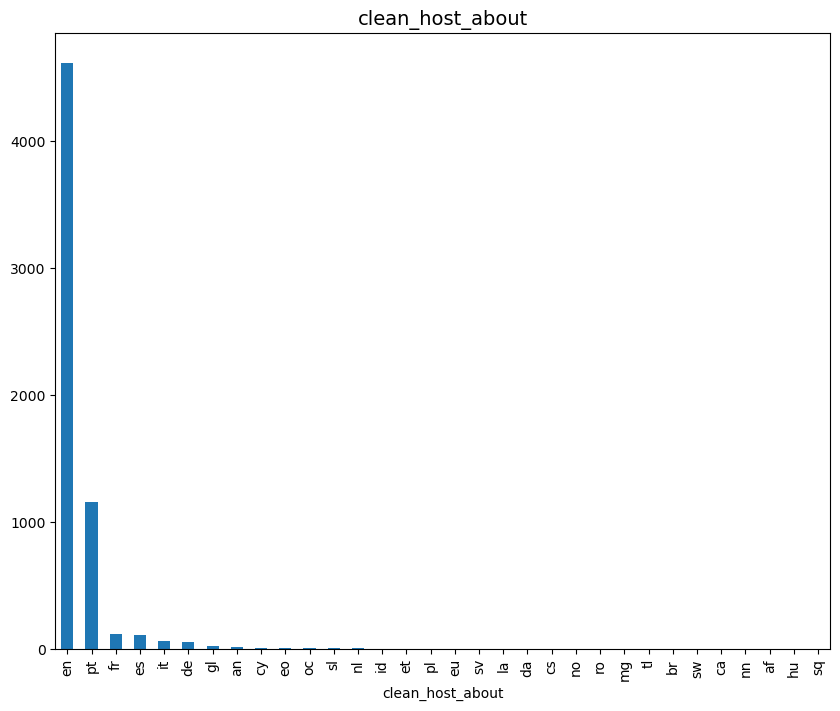

In [ ]:
get_languages_num(train_df, 'clean_host_about')

Number of tagged languages (estimated): 53
Data in English (estimated): 66.13716193212485%
Data in Portuguese (estimated): 5.89291991552282%
Data in French (estimated): 14.430872368045925%
Data in German (estimated): 4.034255883924147%
Data in Spanish (estimated): 5.385005023790345%


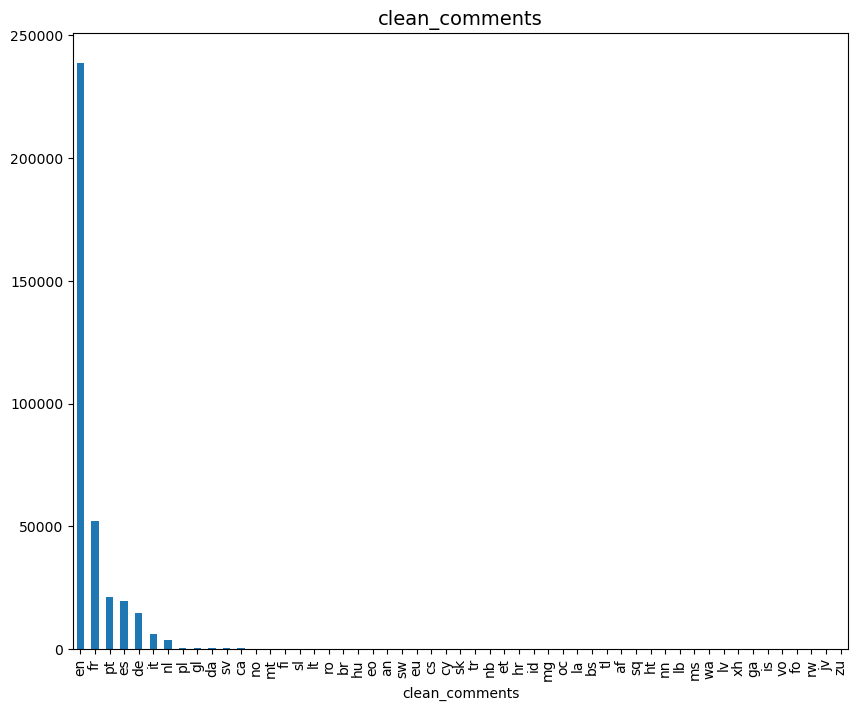

In [ ]:
get_languages_num(train_reviews_df, 'clean_comments')

# 2. Translation: via Google Colab and Google Cloud Translation API

In [ ]:
"""
!pip install google-cloud-translate

import os
from google.cloud import translate_v2 as translate
from google.colab import files

# Upload JSON key file here
files.upload()

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'tm-project-423616-22329ded499b.json'

# Init Google Cloud Translation API client
translate_client = translate.Client()


# Function to translate text to English
def translate_to_english(text):
    try:
        # Translate the text to English
        result = translate_client.translate(text, target_language='en')
        return result['translatedText']
    except Exception as e:
        print(f"Error translating text: {text}, error: {e}")
        return text


train_df = pd.read_excel("/content/sample_data/train.xlsx")
test_df = pd.read_excel("/content/sample_data/test_reviews.xlsx")

def modify_df(df):
    df['description_english'] = df['description'].apply(translate_to_english)
    df['host_about_english'] = df['host_about'].apply(translate_to_english)

modify_df(train_df)
modify_df(test_df)

test_df.to_csv("/content/sample_data/translated_test.csv")
train_df.to_csv("/content/sample_data/translated_train.csv")
"""

'\n!pip install google-cloud-translate\n\nimport os\nfrom google.cloud import translate_v2 as translate\nfrom google.colab import files\n\n# Upload JSON key file here\nfiles.upload()\n\nos.environ[\'GOOGLE_APPLICATION_CREDENTIALS\'] = \'tm-project-423616-22329ded499b.json\'\n\n# Init Google Cloud Translation API client\ntranslate_client = translate.Client()\n\n\n# Function to translate text to English\ndef translate_to_english(text):\n    try:\n        # Translate the text to English\n        result = translate_client.translate(text, target_language=\'en\')\n        return result[\'translatedText\']\n    except Exception as e:\n        print(f"Error translating text: {text}, error: {e}")\n        return text\n\n\ntrain_df = pd.read_excel("/content/sample_data/train.xlsx")\ntest_df = pd.read_excel("/content/sample_data/test_reviews.xlsx")\n\ndef modify_df(df):\n    df[\'description_english\'] = df[\'description\'].apply(translate_to_english)\n    df[\'host_about_english\'] = df[\'host_a

# 3. Data Exploration and Preprocessing (after translation)

In [ ]:
df_train = pd.read_csv("data/translated_train.csv", index_col = 0)
df_test = pd.read_csv("data/translated_test.csv", index_col = 0)

In [ ]:
print(f'Train info: {df_train.info()}')
print("-"*50)
print(f'Test info: {df_test.info()}')

<class 'pandas.core.frame.DataFrame'>
Index: 6248 entries, 0 to 6247
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                6248 non-null   int64 
 1   description          6248 non-null   object
 2   host_about           6248 non-null   object
 3   unlisted             6248 non-null   int64 
 4   language             6248 non-null   object
 5   description_english  6248 non-null   object
 6   host_about_english   6248 non-null   object
dtypes: int64(2), object(5)
memory usage: 390.5+ KB
Train info: None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 0 to 694
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                695 non-null    int64 
 1   description          695 non-null    object
 2   host_about           695 non-null    o

In [ ]:
df_reviews_train = pd.read_excel("data/train_reviews.xlsx")
df_reviews_test = pd.read_excel("data/test_reviews.xlsx")

In [ ]:
print(f'Train reviews info: {df_reviews_train.info()}')
print("-"*50)
print(f'Test reviews info: {df_reviews_test.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361281 entries, 0 to 361280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     361281 non-null  int64 
 1   comments  361279 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB
Train reviews info: None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41866 entries, 0 to 41865
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     41866 non-null  int64 
 1   comments  41866 non-null  object
dtypes: int64(1), object(1)
memory usage: 654.3+ KB
Test reviews info: None


In [ ]:
df_train.head()

,index,description,host_about,unlisted,language,description_english,host_about_english
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration: 20835/AL
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re..."
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,"Charming Apartment in Chiado, Between Largo do...",Hello!_x000D_\nI m Portuguese and i love to me...
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,Nice apartment by the sea.<br /> 2 min. walk t...,We are a family with two children aged 17 and ...


In [ ]:
columns = ['index', 'description_english', 'host_about_english', 'unlisted']
train = df_train[columns]

In [ ]:
train.duplicated().sum()

0

In [ ]:
train = train.drop_duplicates()
train.shape

(6248, 4)

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()
#spell = Speller(lang='en')

In [ ]:
def cleaning_and_preprocessing(text_list, lemmatize, stemmer, autocorrect, contractions):
    '''
    Function to pre-process and clean the text data,
    including cleaning, optionally lemmatizing, stemming, and expanding contractions.
    '''
    updates = []
    pattern = r'<\/?[\w\s]*>|<.+[\W]>'
    xlsx_break = '_x000D_'
    exclude = set(string.punctuation)

    for text in tqdm(text_list):

        # Lowercase text
        text = text.lower()

        # Expand contractions
        #if contractions:
            #text = contractions.fix(text)

        # Remove unnecessary tags and all non-alphabetic characters
        for char in ["<br />", "<br/>", "<br/>", "_x000d_", "n_x000d_", "<b>", "</b>"]:
            text = re.sub(char, "", text)

        text = re.sub("[^a-zA-Z]"," ", text)
        text = re.sub(pattern, ' ', str(text)).replace(xlsx_break, ' ').replace('\n', ' ')
        text = " ".join([word for word in text.split() if word not in stop_words])
        text = ''.join(word for word in text if word not in exclude)

        # English autocorrector
        #if autocorrect:
            #text = " ".join(spell(word) for word in text.split())
        # Lemmatizing
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        # Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())

        updates.append(text)

    return updates

In [ ]:
train["description_english_clean"] = cleaning_and_preprocessing(train["description_english"],
                                                                lemmatize=True, stemmer=False,
                                                                autocorrect=False, contractions=False)

train["host_about_english_clean"] = cleaning_and_preprocessing(train["host_about_english"],
                                                               lemmatize=True, stemmer=False,
                                                               autocorrect=False, contractions=False)
train.head()

100%|████████████████████████████████████████████████████████████████████████████| 6248/6248 [00:01<00:00, 5980.71it/s]


,index,description_english,host_about_english,unlisted,description_english_clean,host_about_english_clean
0,1,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration: 20835/AL,0,shared mixed room hostel shared bathroom locat...,local accommodation registration al
1,2,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b...",1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...
3,4,"Charming Apartment in Chiado, Between Largo do...",Hello!_x000D_\nI m Portuguese and i love to me...,0,charming apartment chiado largo carmo travessa...,hello portuguese love meet people around word ...
4,5,Nice apartment by the sea.<br /> 2 min. walk t...,We are a family with two children aged 17 and ...,0,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...


In [ ]:
def cleaning_preserving_all_words(text_list):
    updates = []
    pattern = r'<\/?[\w\s]*>|<.+[\W]>'
    xlsx_break = '_x000D_'

    # Define a set of punctuation characters excluding the full stop (.)
    exclude = set(string.punctuation) - {'.'}

    for text in tqdm(text_list):
        # Lowercase text
        text = text.lower()

        for char in ["<br />", "<br/>", "<br/>", "_x000d_", "n_x000d_", "<b>", "</b>"]:
            text = re.sub(char, "", text)

        text = re.sub("[^a-zA-Z.]", " ", text)
        text = re.sub(pattern, ' ', str(text)).replace(xlsx_break, ' ').replace('\n', ' ')
        text = ''.join(char for char in text if char not in exclude)

        updates.append(text)

    return updates

In [ ]:
train["description_english_prep"] = cleaning_preserving_all_words(train["description_english"])
train["host_about_english_prep"] = cleaning_preserving_all_words(train["host_about_english"])
train.head()

100%|███████████████████████████████████████████████████████████████████████████| 6248/6248 [00:00<00:00, 20079.50it/s]


,index,description_english,host_about_english,unlisted,description_english_clean,host_about_english_clean,description_english_prep,host_about_english_prep
0,1,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration: 20835/AL,0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,this is a shared mixed room in our hostel wit...,local accommodation registration al
1,2,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b...",1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,my space is close to parque eduardo vii salda...,i am friendly host and i will try to always b...
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,trafaria s house is a cozy and familiar villa ...,i am a social person liking to communicate re...
3,4,"Charming Apartment in Chiado, Between Largo do...",Hello!_x000D_\nI m Portuguese and i love to me...,0,charming apartment chiado largo carmo travessa...,hello portuguese love meet people around word ...,charming apartment in chiado between largo do...,hello i m portuguese and i love to meet peopl...
4,5,Nice apartment by the sea.<br /> 2 min. walk t...,We are a family with two children aged 17 and ...,0,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,nice apartment by the sea. min. walk to the ...,we are a family with two children aged and ...


In [ ]:
train.iloc[10]["description_english"]

'Dear guests, I have the pleaser to receive you at my home with one guest room (2 people) with a living home space with TV (Netflix and Mbo) W.C. private ,kitchen (shared). I’m situated 10 minutes from metro Anjos, 10 min from Graça and 15 min walking to city centre. <br />My space is good for couples, solo adventures, and business travelers.<br /><br /><b>The space</b><br />It is a 1902 apartment with the typical characteristics of the houses of the time, wooden floors and shutters on the windows.<br /><br /><b>Guest access</b><br />The neighborhood is very quiet, you can walk without problem. It has bus and tram 28 to 2 minutes walk. Next to the apartment there is a garage where you can park for around 9 euros a day.<br /><br /><b>Other things to note</b><br />The apartment is situated in a quiet street in Lisbon but very close to the center (15 minutes walking) of Grace. Alfama, Castelo. It has the metro dos Anjos 10 minutes walking and electric 28-2 minutes. The street has a cafe w

In [ ]:
train.iloc[10]["description_english_clean"]

'dear guest pleaser receive home one guest room people living home space tv netflix mbo w c private kitchen shared situated minute metro anjos min gra min walking city centre space good couple solo adventure business traveler spaceit apartment typical characteristic house time wooden floor shutter window guest accessthe neighborhood quiet walk without problem bus tram minute walk next apartment garage park around euro day thing notethe apartment situated quiet street lisbon close center minute walking grace alfama castelo metro do anjos minute walking electric minute street cafe wh'

In [ ]:
# Fetch wordcount for each abstract
train['word_count_description']  = train['description_english_clean'].apply(lambda x: len(str(x).split(' ')))
train['word_count_host']  = train['host_about_english_clean'].apply(lambda x: len(str(x).split(' ')))
train[['word_count_description', 'word_count_host']].head()

,word_count_description,word_count_host
0,70,4
1,14,12
2,99,23
3,27,16
4,67,17


In [ ]:
train.word_count_description.describe()

count    6248.000000
mean       73.224712
std        25.960938
min         2.000000
25%        56.000000
50%        85.000000
75%        92.000000
max       147.000000
Name: word_count_description, dtype: float64

In [ ]:
train.word_count_host.describe()

count    6248.000000
mean       39.450384
std        44.652070
min         1.000000
25%        14.000000
50%        28.000000
75%        54.000000
max      1192.000000
Name: word_count_host, dtype: float64

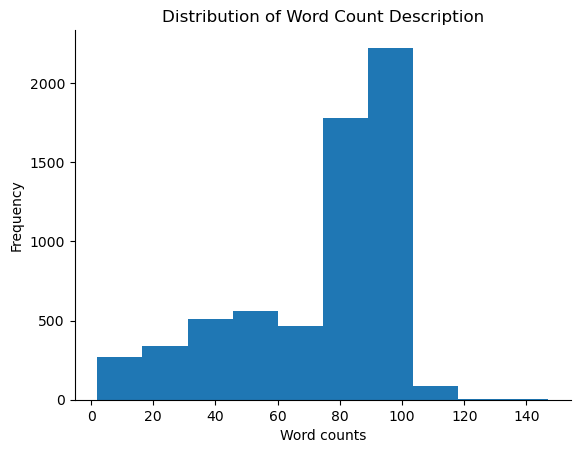

In [ ]:
train['word_count_description'].hist()
plt.grid(False)
plt.title('Distribution of Word Count Description')
plt.xlabel('Word counts')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

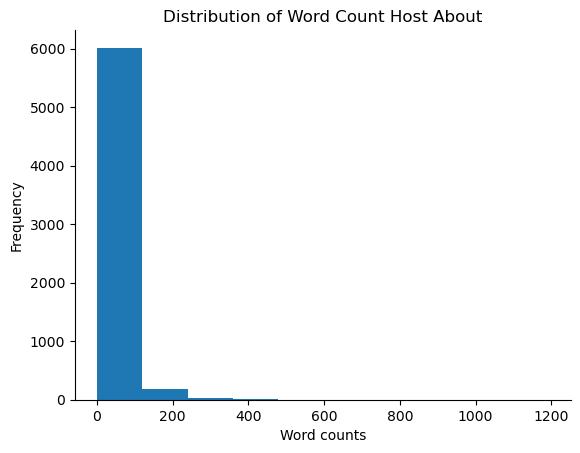

In [ ]:
train['word_count_host'].hist()
plt.grid(False)
plt.title('Distribution of Word Count Host About')
plt.xlabel('Word counts')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
all_words_description = ' '.join(train['description_english_clean']).split()
freq_description = pd.Series(all_words_description).value_counts()
freq_description.sort_values(ascending=False)[0:10]

apartment    10543
lisbon        7035
room          6688
bedroom       5259
bed           4834
located       4458
kitchen       4222
guest         4013
bathroom      3733
living        3671
Name: count, dtype: int64

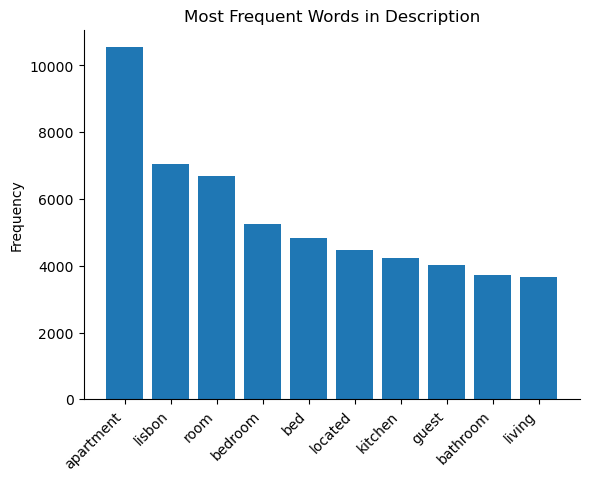

In [ ]:
x_labels = freq_description.index[0:10]
values = freq_description[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Most Frequent Words in Description')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
all_words_host = ' '.join(train['host_about_english_clean']).split()
freq_host = pd.Series(all_words_host).value_counts()
freq_host.sort_values(ascending=False)[0:10]

lisbon        4906
love          3479
home          2587
like          2477
apartment     2464
guest         2407
stay          2286
experience    2219
city          2197
portugal      2067
Name: count, dtype: int64

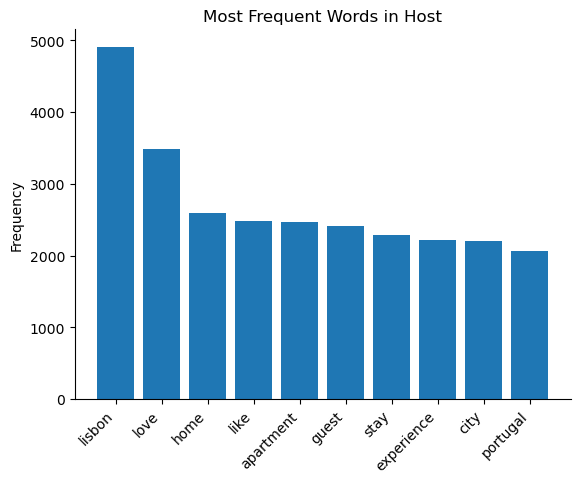

In [ ]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values)
plt.xticks(x_labels, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Most Frequent Words in Host')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
train_cleaned = train[["index", "unlisted", "description_english_clean", "host_about_english_clean", "description_english_prep", "host_about_english_prep"]]
train_cleaned.head()

,index,unlisted,description_english_clean,host_about_english_clean,description_english_prep,host_about_english_prep
0,1,0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,this is a shared mixed room in our hostel wit...,local accommodation registration al
1,2,1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,my space is close to parque eduardo vii salda...,i am friendly host and i will try to always b...
2,3,1,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,trafaria s house is a cozy and familiar villa ...,i am a social person liking to communicate re...
3,4,0,charming apartment chiado largo carmo travessa...,hello portuguese love meet people around word ...,charming apartment in chiado between largo do...,hello i m portuguese and i love to meet peopl...
4,5,0,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,nice apartment by the sea. min. walk to the ...,we are a family with two children aged and ...


# 4. Models using only Description and Host information

## 4.1 Data split and feature selection

In [ ]:
y = train_cleaned['unlisted']
X = train_cleaned[["description_english_clean", "host_about_english_clean", "description_english_prep", "host_about_english_prep"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
def train_validate(model, X_train, X_test, y_train, y_test):
    '''
    function to train and validate the model's performance
    with essential metrics
    '''

    model.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Predict on the training set
    y_train_pred = model.predict(X_train)

    # Calculate metrics for the training set
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    train_f1_default = f1_score(y_train, y_train_pred)
    train_f1_weighted = f1_score(y_train, y_train_pred, average="weighted")
    train_f1_macro = f1_score(y_train, y_train_pred, average="macro")

    # Calculate metrics for the test set
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    test_f1_default = f1_score(y_test, y_test_pred)
    test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
    test_f1_macro = f1_score(y_test, y_test_pred, average="macro")

    # Print training set metrics
    print("\nTraining Set Metrics:")
    print("-"*21)
    print("Balanced Accuracy:", np.round(train_balanced_acc, 2))
    print("Default F1 score:", np.round(train_f1_default, 2))
    print("Weighted F1 score:", np.round(train_f1_weighted, 2))
    print("Macro F1 score:", np.round(train_f1_macro, 2))
    print("="*23)
    # Print test set metrics
    print("Test Set Metrics:")
    print("-"*21)
    print("Balanced Accuracy:", np.round(test_balanced_acc, 2))
    print("Default F1 score:", np.round(test_f1_default, 2))
    print("Weighted F1 score:", np.round(test_f1_weighted, 2))
    print("Macro F1 score:", np.round(test_f1_macro, 2))
    print("="*23)
    print("Classification Report:\n", classification_report(y_test, y_test_pred))

    return test_balanced_acc, test_f1_default, test_f1_weighted, test_f1_macro

## 4.2 TF_IDF

In [ ]:
# Create TF-IDF features
tfidf = TfidfVectorizer(max_df=0.7, ngram_range=(1, 3), max_features=5000)

tfidf_description_train = tfidf.fit_transform(X_train["description_english_clean"])
tfidf_host_about_train = tfidf.fit_transform(X_train["host_about_english_clean"])

tfidf_description_test = tfidf.transform(X_test["description_english_clean"])
tfidf_host_about_test = tfidf.transform(X_test["host_about_english_clean"])

# Combine TF-IDF features
combined_tfidf_train = hstack([tfidf_description_train, tfidf_host_about_train])
combined_tfidf_test = hstack([tfidf_description_test, tfidf_host_about_test])

# Use TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=300)
reduced_features_train = svd.fit_transform(combined_tfidf_train)
reduced_features_test = svd.transform(combined_tfidf_test)

In [ ]:
reduced_features_train.shape

(4998, 300)

### 4.2.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
balanced_acc_knn, f1_default_knn, f1_weighted_knn, f1_macro_knn = train_validate(knn, reduced_features_train, reduced_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.74
Default F1 score: 0.64
Weighted F1 score: 0.82
Macro F1 score: 0.77
Test Set Metrics:
---------------------
Balanced Accuracy: 0.59
Default F1 score: 0.34
Weighted F1 score: 0.71
Macro F1 score: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86       908
           1       0.71      0.22      0.34       342

    accuracy                           0.76      1250
   macro avg       0.74      0.59      0.60      1250
weighted avg       0.75      0.76      0.71      1250



### 4.2.2 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
balanced_acc_logreg, f1_default_logreg, f1_weighted_logreg, f1_macro_logreg = train_validate(log_reg, reduced_features_train, reduced_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.63
Default F1 score: 0.43
Weighted F1 score: 0.75
Macro F1 score: 0.65
Test Set Metrics:
---------------------
Balanced Accuracy: 0.56
Default F1 score: 0.25
Weighted F1 score: 0.69
Macro F1 score: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85       908
           1       0.69      0.15      0.25       342

    accuracy                           0.75      1250
   macro avg       0.72      0.56      0.55      1250
weighted avg       0.74      0.75      0.69      1250



### 4.2.3 Random Forest

In [ ]:
# Initialize and train Random Forest classifier
rf = RandomForestClassifier(random_state=42)
balanced_acc_rf, f1_default_rf, f1_weighted_rf, f1_macro_rf = train_validate(rf, reduced_features_train, reduced_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 0.99
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.53
Default F1 score: 0.13
Weighted F1 score: 0.65
Macro F1 score: 0.49
Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85       908
           1       0.86      0.07      0.13       342

    accuracy                           0.74      1250
   macro avg       0.80      0.53      0.49      1250
weighted avg       0.77      0.74      0.65      1250



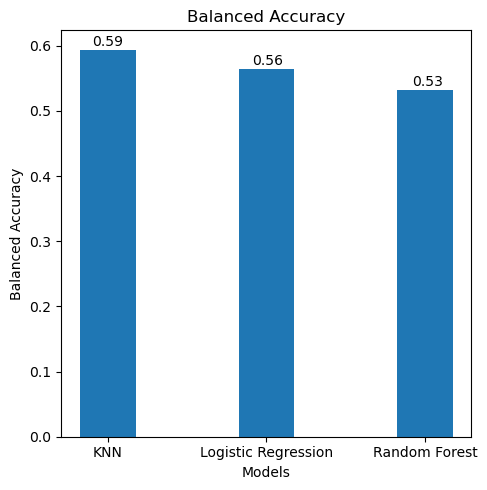

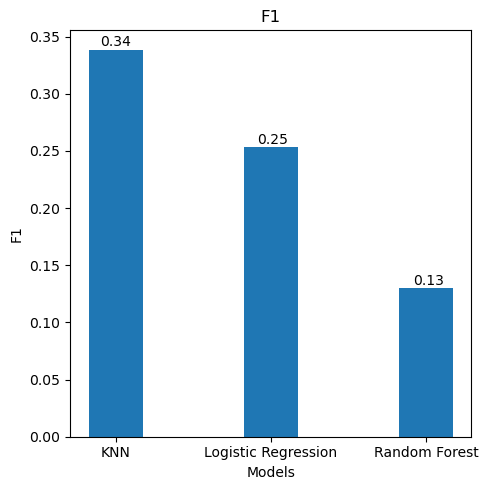

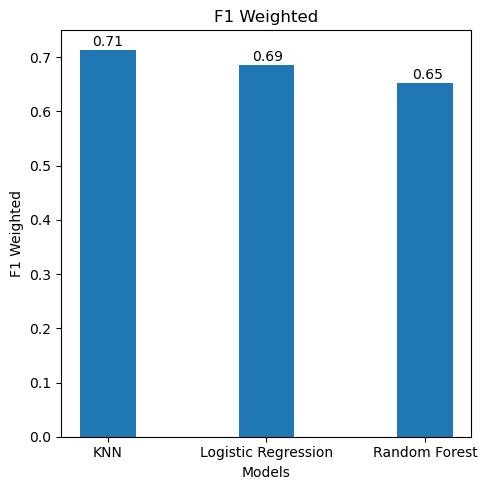

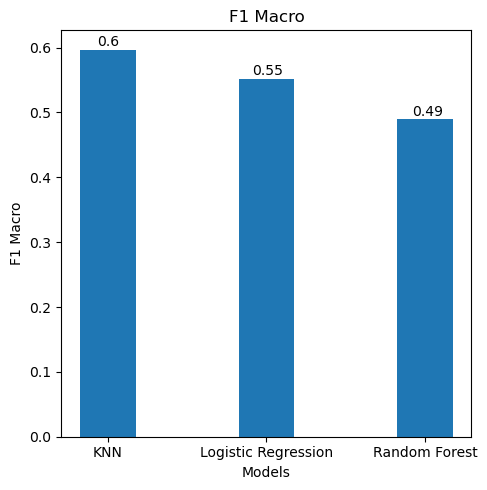

In [ ]:
models = ['KNN', 'Logistic Regression', 'Random Forest']

# Metrics for each model
balanced_accuracy = [balanced_acc_knn, balanced_acc_logreg, balanced_acc_rf]
f1_default = [f1_default_knn, f1_default_logreg, f1_default_rf]
f1_weighted = [f1_weighted_knn, f1_weighted_logreg, f1_weighted_rf]
f1_macro = [f1_macro_knn, f1_macro_logreg, f1_macro_rf]

def plot_metric(metric_values, metric_name):
    '''
    Function to plot comparison of models' performances due to metrics
    '''
    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(5, 5))
    bars = ax.bar(x, metric_values, width, label=metric_name)

    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(models)

    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    textcoords="offset points",
                    ha='center', va='bottom')


    fig.tight_layout()
    plt.show()

# Plot the graphs
plot_metric(balanced_accuracy, 'Balanced Accuracy')
plot_metric(f1_default, 'F1')
plot_metric(f1_weighted, 'F1 Weighted')
plot_metric(f1_macro, 'F1 Macro')

## 4.3 Doc2Vec

In [ ]:
#!pip uninstall scipy -y
#!pip install scipy==1.12.0

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
# Combine the text columns for Doc2Vec
X_train_combined = X_train['description_english_prep'] + " " + X_train['host_about_english_prep']
X_test_combined = X_test['description_english_prep'] + " " + X_test['host_about_english_prep']

# Prepare TaggedDocument
train_tagged = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(X_train_combined)]
test_tagged = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(X_test_combined)]

# Train Doc2Vec model
model = Doc2Vec(vector_size=300, min_count=2, epochs=40)
model.build_vocab(train_tagged)
model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)

# Transform text data into vectors
def vectorize_docs(model, tagged_docs):
    vectors = [model.infer_vector(doc.words) for doc in tagged_docs]
    return vectors

X_train_vectors = vectorize_docs(model, train_tagged)
X_test_vectors = vectorize_docs(model, test_tagged)

### 4.3.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
balanced_acc_knn, f1_default_knn, f1_weighted_knn, f1_macro_knn = train_validate(knn, X_train_vectors, X_test_vectors, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.74
Default F1 score: 0.61
Weighted F1 score: 0.73
Macro F1 score: 0.69
Test Set Metrics:
---------------------
Balanced Accuracy: 0.58
Default F1 score: 0.43
Weighted F1 score: 0.6
Macro F1 score: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.57      0.66       908
           1       0.34      0.60      0.43       342

    accuracy                           0.58      1250
   macro avg       0.57      0.58      0.55      1250
weighted avg       0.67      0.58      0.60      1250



### 4.3.2 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
balanced_acc_logreg, f1_default_logreg, f1_weighted_logreg, f1_macro_logreg = train_validate(log_reg, X_train_vectors, X_test_vectors, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.59
Default F1 score: 0.33
Weighted F1 score: 0.71
Macro F1 score: 0.59
Test Set Metrics:
---------------------
Balanced Accuracy: 0.56
Default F1 score: 0.27
Weighted F1 score: 0.68
Macro F1 score: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83       908
           1       0.49      0.19      0.27       342

    accuracy                           0.72      1250
   macro avg       0.62      0.56      0.55      1250
weighted avg       0.68      0.72      0.68      1250



### 4.3.3 Random Forest

In [ ]:
# Initialize and train Random Forest classifier
rf = RandomForestClassifier(random_state=42)
balanced_acc_rf, f1_default_rf, f1_weighted_rf, f1_macro_rf = train_validate(rf, X_train_vectors, X_test_vectors, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 1.0
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.54
Default F1 score: 0.16
Weighted F1 score: 0.66
Macro F1 score: 0.51
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85       908
           1       0.76      0.09      0.16       342

    accuracy                           0.74      1250
   macro avg       0.75      0.54      0.51      1250
weighted avg       0.75      0.74      0.66      1250



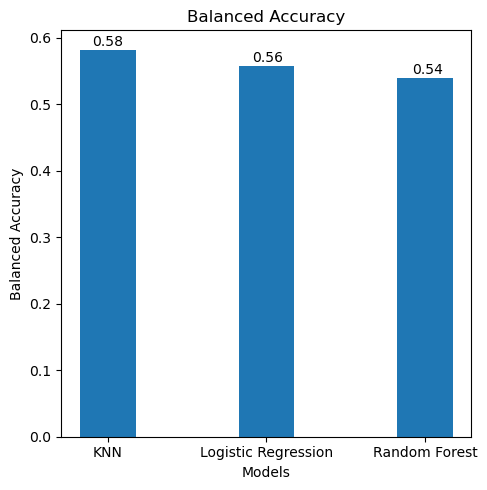

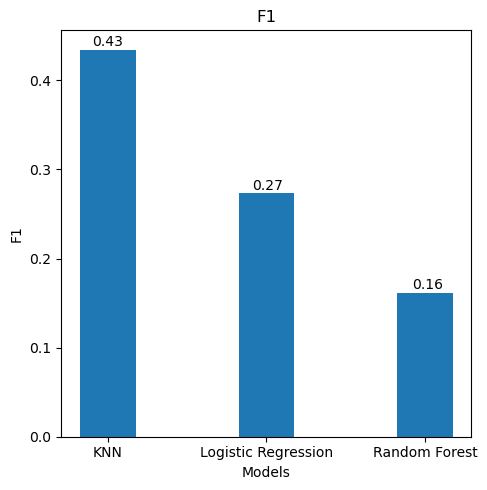

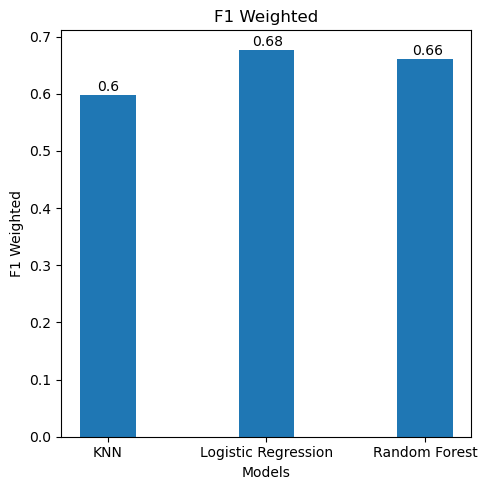

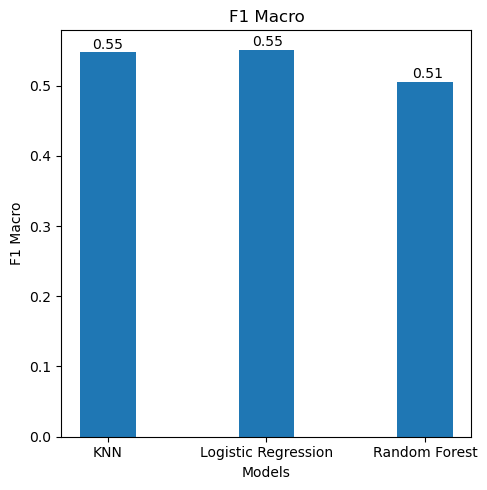

In [ ]:
models = ['KNN', 'Logistic Regression', 'Random Forest']

# Metrics for each model
balanced_accuracy = [balanced_acc_knn, balanced_acc_logreg, balanced_acc_rf]
f1_default = [f1_default_knn, f1_default_logreg, f1_default_rf]
f1_weighted = [f1_weighted_knn, f1_weighted_logreg, f1_weighted_rf]
f1_macro = [f1_macro_knn, f1_macro_logreg, f1_macro_rf]

# Plot the graphs
plot_metric(balanced_accuracy, 'Balanced Accuracy')
plot_metric(f1_default, 'F1')
plot_metric(f1_weighted, 'F1 Weighted')
plot_metric(f1_macro, 'F1 Macro')

## 4.4 GloVe

In [ ]:
from torchtext.vocab import GloVe

In [ ]:
# Load GloVe embeddings
glove = GloVe(name='6B', dim=300)

In [ ]:
# Convert text to GloVe embeddings
def text_to_glove_embeddings(text, glove, embedding_dim=300):
    words = text.split()
    embeddings = [glove[word] if word in glove.stoi else np.zeros(embedding_dim) for word in words]
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)
    return np.mean(embeddings, axis=0)

# Apply GloVe embeddings to dataset
def apply_glove_embeddings(dataset, column_name, glove, embedding_dim=300):
    return np.array([text_to_glove_embeddings(text, glove, embedding_dim) for text in dataset[column_name]])

# Apply GloVe embeddings to the train and test sets
embedding_dim = 300
glove_description_train = apply_glove_embeddings(X_train, "description_english_clean", glove, embedding_dim)
glove_host_about_train = apply_glove_embeddings(X_train, "host_about_english_clean", glove, embedding_dim)

glove_description_test = apply_glove_embeddings(X_test, "description_english_clean", glove, embedding_dim)
glove_host_about_test = apply_glove_embeddings(X_test, "host_about_english_clean", glove, embedding_dim)

# Combine GloVe features
combined_glove_train = np.hstack([glove_description_train, glove_host_about_train])
combined_glove_test = np.hstack([glove_description_test, glove_host_about_test])

"""
# Use TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=200)
reduced_glove_train = svd.fit_transform(combined_glove_train)
reduced_glove_test = svd.transform(combined_glove_test)
"""

'\n# Use TruncatedSVD to reduce dimensionality\nsvd = TruncatedSVD(n_components=200)\nreduced_glove_train = svd.fit_transform(combined_glove_train)\nreduced_glove_test = svd.transform(combined_glove_test)\n'

### 4.4.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
balanced_acc_knn, f1_default_knn, f1_weighted_knn, f1_macro_knn = train_validate(knn, combined_glove_train, combined_glove_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.74
Default F1 score: 0.63
Weighted F1 score: 0.82
Macro F1 score: 0.76
Test Set Metrics:
---------------------
Balanced Accuracy: 0.62
Default F1 score: 0.43
Weighted F1 score: 0.73
Macro F1 score: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.85       908
           1       0.60      0.33      0.43       342

    accuracy                           0.76      1250
   macro avg       0.69      0.62      0.64      1250
weighted avg       0.73      0.76      0.73      1250



#### 4.4.2 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
balanced_acc_logreg, f1_default_logreg, f1_weighted_logreg, f1_macro_logreg = train_validate(log_reg, combined_glove_train, combined_glove_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.62
Default F1 score: 0.4
Weighted F1 score: 0.74
Macro F1 score: 0.63
Test Set Metrics:
---------------------
Balanced Accuracy: 0.58
Default F1 score: 0.31
Weighted F1 score: 0.7
Macro F1 score: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.95      0.84       908
           1       0.60      0.21      0.31       342

    accuracy                           0.74      1250
   macro avg       0.68      0.58      0.58      1250
weighted avg       0.72      0.74      0.70      1250



### 4.4.3 Random Forest

In [ ]:
# Initialize and train Random Forest classifier
rf = RandomForestClassifier(random_state=42)
balanced_acc_rf, f1_default_rf, f1_weighted_rf, f1_macro_rf = train_validate(rf, combined_glove_train, combined_glove_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 1.0
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.65
Default F1 score: 0.46
Weighted F1 score: 0.76
Macro F1 score: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87       908
           1       0.80      0.32      0.46       342

    accuracy                           0.79      1250
   macro avg       0.80      0.65      0.67      1250
weighted avg       0.80      0.79      0.76      1250



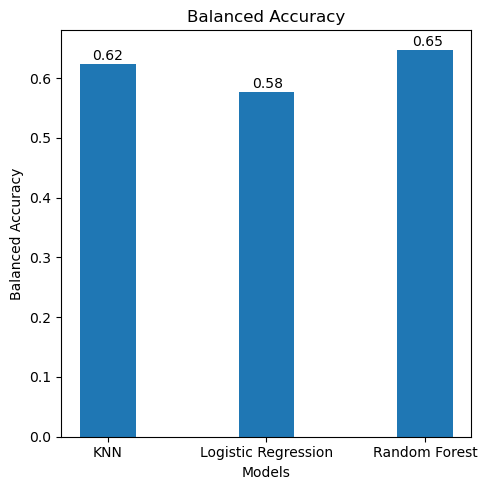

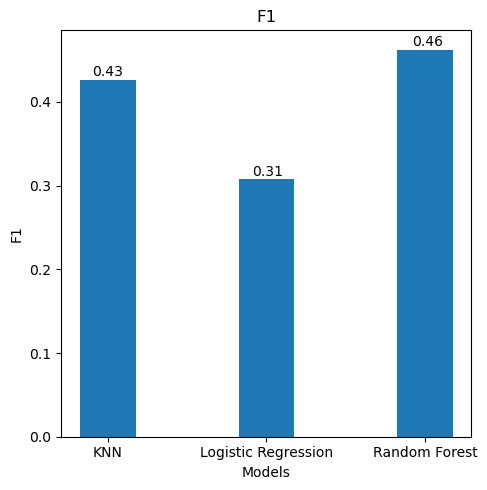

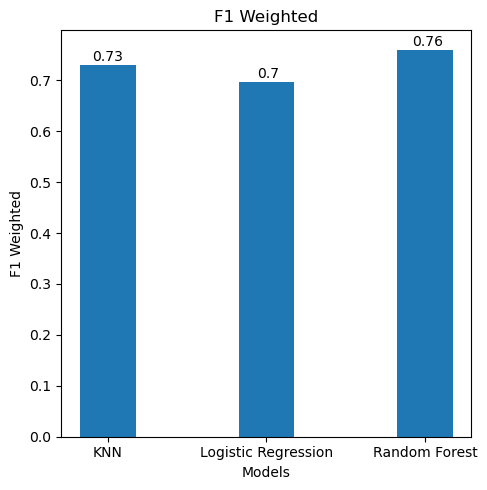

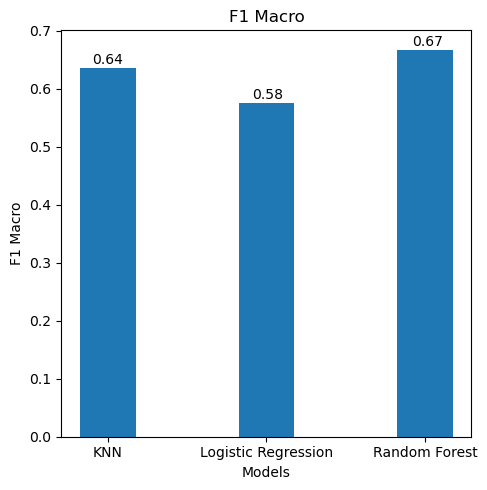

In [ ]:
models = ['KNN', 'Logistic Regression', 'Random Forest']

# Metrics for each model
balanced_accuracy = [balanced_acc_knn, balanced_acc_logreg, balanced_acc_rf]
f1_default = [f1_default_knn, f1_default_logreg, f1_default_rf]
f1_weighted = [f1_weighted_knn, f1_weighted_logreg, f1_weighted_rf]
f1_macro = [f1_macro_knn, f1_macro_logreg, f1_macro_rf]

# Plot the graphs
plot_metric(balanced_accuracy, 'Balanced Accuracy')
plot_metric(f1_default, 'F1')
plot_metric(f1_weighted, 'F1 Weighted')
plot_metric(f1_macro, 'F1 Macro')

# 5. Models combining Description, Host information and Reviews

## 5.1 Merging the data

In [ ]:
# let's create a column with number of reviews per listing. It'll be our additional feature to train future models
df_reviews_train["num_reviews"] = df_reviews_train.groupby('index')['comments'].transform('count')
df_reviews_train.tail(20)

,index,comments,num_reviews
361261,6248,"My stay was great. The bed was insanely soft, ...",275
361262,6248,Just perfect!,275
361263,6248,Super appartement. Hôte très accueillante et s...,275
361264,6248,Personne très accueillante. Emplacement de l'a...,275
361265,6248,Ana is a great host and the place is located i...,275
361266,6248,"Studio au calme,confortable, proche du métro m...",275
361267,6248,Ana’s apartments was a great choice for my wee...,275
361268,6248,Excelente comunicação!,275
361269,6248,"La ubicación es muy buena , el trato con la an...",275
361270,6248,Ótima localização. Casa suficientemente espaço...,275


In [ ]:
df_reviews_train = df_reviews_train.dropna(subset=['comments'])
df_reviews_train.shape

(361279, 3)

Taking into account we have a large number of data and limited resources, we'll limit a number of reviews to 10 per listing

In [ ]:
reviews_limited = df_reviews_train.groupby("index").apply(lambda group: group.sample(10, random_state=42) if len(group) > 10 else group)

In [ ]:
reviews_limited = reviews_limited[["comments", "num_reviews"]].reset_index()

In [ ]:
reviews_limited.columns

Index(['index', 'level_1', 'comments', 'num_reviews'], dtype='object')

In [ ]:
reviews_limited = reviews_limited[['index', 'comments', 'num_reviews']]
reviews_limited.head(20)

,index,comments,num_reviews
0,1,Very Nice.,50
1,1,top,50
2,1,"Un lugar muy acogedor, buen lugar donde hosped...",50
3,1,The property is absolutely clean and stylish. ...,50
4,1,"Everything is correct, like the photos said. B...",50
5,1,Personnes très agréable et très attentionné po...,50
6,1,You have to be there,50
7,1,Minha estadia foi quando estava comecando o su...,50
8,1,Great location and very good communication,50
9,1,Beside to big street and park.<br/>You can fin...,50


In [ ]:
# let's merge the dataframe with limited reviews with our train dataframe with listings descriptions and host about
aggregated_comments = reviews_limited.groupby('index').agg({
    'comments': lambda x: 'sep '.join(x),
    'num_reviews': 'first'
}).reset_index()

merged_df = pd.merge(train_cleaned, aggregated_comments, on='index',  how='left')

merged_df.head()

,index,unlisted,description_english_clean,host_about_english_clean,description_english_prep,host_about_english_prep,comments,num_reviews
0,1,0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,this is a shared mixed room in our hostel wit...,local accommodation registration al,"Very Nice.sep topsep Un lugar muy acogedor, bu...",50.0
1,2,1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,my space is close to parque eduardo vii salda...,i am friendly host and i will try to always b...,NaN,NaN
2,3,1,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,trafaria s house is a cozy and familiar villa ...,i am a social person liking to communicate re...,NaN,NaN
3,4,0,charming apartment chiado largo carmo travessa...,hello portuguese love meet people around word ...,charming apartment in chiado between largo do...,hello i m portuguese and i love to meet peopl...,NaN,NaN
4,5,0,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,nice apartment by the sea. min. walk to the ...,we are a family with two children aged and ...,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...,41.0


In [ ]:
merged_df.shape

(6248, 8)

In [ ]:
merged_df["unlisted"].value_counts()

unlisted
0    4540
1    1708
Name: count, dtype: int64

In [ ]:
merged_df["comments"] = merged_df["comments"].fillna("")

## 5.2 Comments Pre-processing

In [ ]:
merged_df["comments_clean"] = cleaning_preserving_all_words(merged_df["comments"])

100%|████████████████████████████████████████████████████████████████████████████| 6248/6248 [00:01<00:00, 5923.39it/s]


In [ ]:
merged_df.head()

,index,unlisted,description_english_clean,host_about_english_clean,description_english_prep,host_about_english_prep,comments,num_reviews,comments_clean
0,1,0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,this is a shared mixed room in our hostel wit...,local accommodation registration al,"Very Nice.sep topsep Un lugar muy acogedor, bu...",50.0,very nice.sep topsep un lugar muy acogedor bu...
1,2,1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,my space is close to parque eduardo vii salda...,i am friendly host and i will try to always b...,,NaN,
2,3,1,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,trafaria s house is a cozy and familiar villa ...,i am a social person liking to communicate re...,,NaN,
3,4,0,charming apartment chiado largo carmo travessa...,hello portuguese love meet people around word ...,charming apartment in chiado between largo do...,hello i m portuguese and i love to meet peopl...,,NaN,
4,5,0,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,nice apartment by the sea. min. walk to the ...,we are a family with two children aged and ...,Vista fabulosa.<br/>Bom apartamento. <br/>Loca...,41.0,vista fabulosa.bom apartamento. localiza o fa...


In [ ]:
full_df = merged_df[["description_english_clean","host_about_english_clean", "num_reviews", "comments_clean","unlisted"]]
full_df["num_reviews"] = full_df["num_reviews"].fillna(0)
full_df.head(20)

,description_english_clean,host_about_english_clean,num_reviews,comments_clean,unlisted
0,shared mixed room hostel shared bathroom locat...,local accommodation registration al,50.0,very nice.sep topsep un lugar muy acogedor bu...,0
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,0.0,,1
2,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,0.0,,1
3,charming apartment chiado largo carmo travessa...,hello portuguese love meet people around word ...,0.0,,0
4,nice apartment sea min walk beach magnificent ...,family two child aged lived portugal several y...,41.0,vista fabulosa.bom apartamento. localiza o fa...,0
5,important response covid property extended cle...,hi homing company develops activity tourism pr...,0.0,,0
6,home rent traveling perfect vacation without c...,globe trotter portuguese nationality german fa...,0.0,,1
7,find tranquility meticulously curated lifestyl...,travel lot love originally israel currently sp...,168.0,perfect location. though it s on a busy stree...,0
8,charming apartment one bedroom double bed doub...,isabel helder portuguese parent three wonderfu...,33.0,lugar maravilhoso. anfitri es muito atenciosos...,0
9,walk original wooden stair entrance apartment ...,serviced holiday apartment casa azenhas mar co...,13.0,respons vel muito simp tica sempre a escuta d...,0


## 5.3 Description & Host (TF-IDF) + Comments (embeddings)

In [ ]:
y = full_df['unlisted']
X = full_df[["description_english_clean", "host_about_english_clean", "num_reviews", "comments_clean"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Create TF-IDF features
tfidf = TfidfVectorizer(max_df=0.7, ngram_range=(1, 3), max_features=5000)

tfidf_description_train = tfidf.fit_transform(X_train["description_english_clean"])
tfidf_host_about_train = tfidf.fit_transform(X_train["host_about_english_clean"])

tfidf_description_test = tfidf.transform(X_test["description_english_clean"])
tfidf_host_about_test = tfidf.transform(X_test["host_about_english_clean"])

# Combine TF-IDF features
combined_tfidf_train = hstack([tfidf_description_train, tfidf_host_about_train])
combined_tfidf_test = hstack([tfidf_description_test, tfidf_host_about_test])

'''
# Use TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=200)
reduced_features_train = svd.fit_transform(combined_tfidf_train)
reduced_features_test = svd.transform(combined_tfidf_test)
'''

'\n# Use TruncatedSVD to reduce dimensionality\nsvd = TruncatedSVD(n_components=200)\nreduced_features_train = svd.fit_transform(combined_tfidf_train)\nreduced_features_test = svd.transform(combined_tfidf_test)\n'

**In the following approach we encode all the reviews per listing at once**

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

comments_train_list = X_train['comments_clean'].tolist()
comments_test_list = X_test['comments_clean'].tolist()
'''
#create sentence embeddings based on the relevant columns
comments_embeddings_train_0 = model.encode(comments_train_list).tolist()
comments_embeddings_test_0 = model.encode(comments_test_list).tolist()

# Convert to numpy arrays
comments_embeddings_train_0 = np.array(comments_embeddings_train_0)
comments_embeddings_test_0 = np.array(comments_embeddings_test_0)

# Save training embeddings
np.save('comments_embeddings_train_0.npy', comments_embeddings_train_0)
# Save test embeddings
np.save('comments_embeddings_test_0.npy', comments_embeddings_test_0)
'''

"\n#create sentence embeddings based on the relevant columns\ncomments_embeddings_train_0 = model.encode(comments_train_list).tolist()\ncomments_embeddings_test_0 = model.encode(comments_test_list).tolist()\n\n# Convert to numpy arrays\ncomments_embeddings_train_0 = np.array(comments_embeddings_train_0)\ncomments_embeddings_test_0 = np.array(comments_embeddings_test_0)\n\n# Save training embeddings\nnp.save('comments_embeddings_train_0.npy', comments_embeddings_train_0)\n# Save test embeddings\nnp.save('comments_embeddings_test_0.npy', comments_embeddings_test_0)\n"

In [ ]:
comments_embeddings_train_0 = np.load('comments_embeddings_train_0.npy')
comments_embeddings_test_0 = np.load('comments_embeddings_test_0.npy')

In [ ]:
# Convert num_reviews to a sparse matrix format and stack horizontally with tf idf vectors
num_reviews_matrix_train = np.array(X_train['num_reviews']).reshape(-1, 1)
num_reviews_matrix_test = np.array(X_test['num_reviews']).reshape(-1, 1)

In [ ]:
combined_features_train = hstack([combined_tfidf_train, num_reviews_matrix_train]).toarray()
combined_features_train = np.hstack([combined_features_train, comments_embeddings_train_0])

combined_features_test = hstack([combined_tfidf_test, num_reviews_matrix_test]).toarray()
combined_features_test = np.hstack([combined_features_test, comments_embeddings_test_0])

### 5.3.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
balanced_acc_knn, f1_default_knn, f1_weighted_knn, f1_macro_knn = train_validate(knn, combined_features_train, combined_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.87
Default F1 score: 0.82
Weighted F1 score: 0.9
Macro F1 score: 0.87
Test Set Metrics:
---------------------
Balanced Accuracy: 0.8
Default F1 score: 0.72
Weighted F1 score: 0.85
Macro F1 score: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       908
           1       0.75      0.69      0.72       342

    accuracy                           0.85      1250
   macro avg       0.82      0.80      0.81      1250
weighted avg       0.85      0.85      0.85      1250



### 5.3.2 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
balanced_acc_logreg, f1_default_logreg, f1_weighted_logreg, f1_macro_logreg = train_validate(log_reg, combined_features_train, combined_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 0.9
Default F1 score: 0.85
Weighted F1 score: 0.92
Macro F1 score: 0.9
Test Set Metrics:
---------------------
Balanced Accuracy: 0.87
Default F1 score: 0.79
Weighted F1 score: 0.88
Macro F1 score: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       908
           1       0.76      0.83      0.79       342

    accuracy                           0.88      1250
   macro avg       0.85      0.87      0.86      1250
weighted avg       0.89      0.88      0.88      1250



### 5.3.3 Random Forest

In [ ]:
# Initialize and train Random Forest classifier
rf = RandomForestClassifier(random_state=42)
balanced_acc_rf, f1_default_rf, f1_weighted_rf, f1_macro_rf = train_validate(rf, combined_features_train, combined_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 1.0
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.87
Default F1 score: 0.8
Weighted F1 score: 0.89
Macro F1 score: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       908
           1       0.77      0.83      0.80       342

    accuracy                           0.88      1250
   macro avg       0.85      0.87      0.86      1250
weighted avg       0.89      0.88      0.89      1250



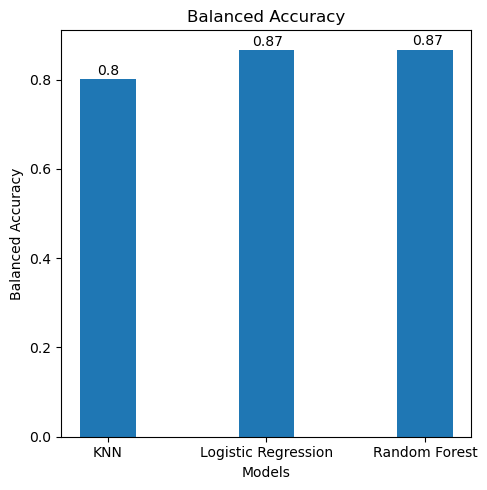

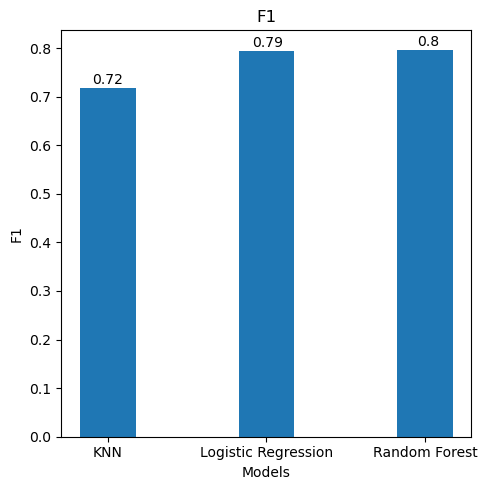

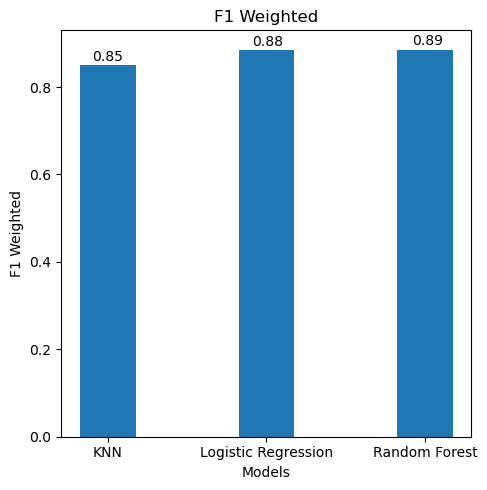

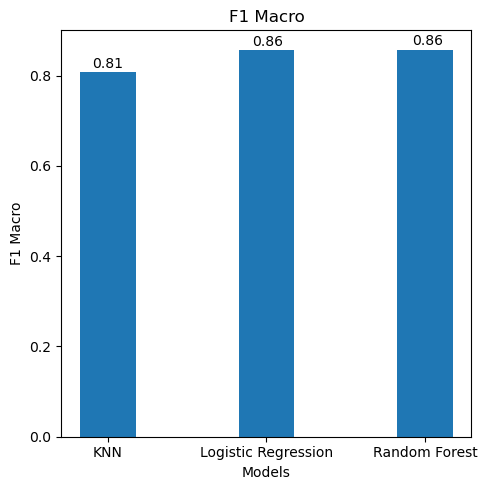

In [ ]:
models = ['KNN', 'Logistic Regression', 'Random Forest']

# Metrics for each model
balanced_accuracy = [balanced_acc_knn, balanced_acc_logreg, balanced_acc_rf]
f1_default = [f1_default_knn, f1_default_logreg, f1_default_rf]
f1_weighted = [f1_weighted_knn, f1_weighted_logreg, f1_weighted_rf]
f1_macro = [f1_macro_knn, f1_macro_logreg, f1_macro_rf]

# Plot the graphs
plot_metric(balanced_accuracy, 'Balanced Accuracy')
plot_metric(f1_default, 'F1')
plot_metric(f1_weighted, 'F1 Weighted')
plot_metric(f1_macro, 'F1 Macro')

## 5.4 Description, Host and Comments (all embeddings)

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [ ]:
df_train.head()

,index,description,host_about,unlisted,language,description_english,host_about_english
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration: 20835/AL
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re..."
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,"Charming Apartment in Chiado, Between Largo do...",Hello!_x000D_\nI m Portuguese and i love to me...
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,Nice apartment by the sea.<br /> 2 min. walk t...,We are a family with two children aged 17 and ...


In [ ]:
train_idx = X_train.index
test_idx = X_test.index

In [ ]:
X_train['description'] = df_train.loc[train_idx, 'description']
X_test['description'] = df_train.loc[test_idx, 'description']

X_train['host_about'] = df_train.loc[train_idx, 'host_about']
X_test['host_about'] = df_train.loc[test_idx, 'host_about']

In [ ]:
X_train.head()

,description_english_clean,host_about_english_clean,num_reviews,comments_clean,description,host_about
725,stay privileged cozy place charming comfortabl...,life lived good friend good food great convers...,66.0,very nice stay big house with possibility to ...,Hospede-se em um local privilegiado e aconcheg...,"Life is to be lived, good friends, good food, ..."
5002,spacious apartment sqm sqft house comfortably ...,architect living abroad renting city flat,237.0,great experience in lisboa in this very nice d...,It is a spacious apartment (200 sqm/2300sqft) ...,"I am an architect, living abroad renting my ci..."
438,would like based prime central area city stree...,name filipe manuel airbnb spirit implies shari...,59.0,je n ai jamais crois mon h te mais juste une ...,Would you like to be based in a prime central ...,Our name is Filipe and Manuel_x000D_\n_x000D_\...
1873,female room hostel shared bathroom located rig...,local accommodation registration al,38.0,lisbon top hostel is located in a marvelous ol...,"This is a FEMALE ONLY room in our hostel, with...",Alojamento Local Registro: 20835/AL
2059,bairro house lisbon charming suite located hea...,name richard partner bairro house entire build...,182.0,had a fantastic stay in this very well present...,Bairro House Lisbon Charming Suites are locate...,"My name is Richard, and I'm partner at Bairro ..."


In [ ]:
X_train['description_clean'] = cleaning_preserving_all_words(X_train['description'])
X_test['description_clean'] = cleaning_preserving_all_words(X_test['description'])

X_train['host_about_clean'] = cleaning_preserving_all_words(X_train['host_about'])
X_test['host_about_clean'] = cleaning_preserving_all_words(X_test['host_about'])

100%|███████████████████████████████████████████████████████████████████████████| 1250/1250 [00:00<00:00, 20318.48it/s]


In [ ]:
desc_train_list = X_train["description_clean"].tolist()
desc_test_list = X_test["description_clean"].tolist()

host_train_list = X_train["host_about_clean"].tolist()
host_test_list = X_test["host_about_clean"].tolist()
'''
#create sentence embeddings based on the relevant columns
desc_embeddings_train_XXX = model.encode(desc_train_list).tolist()
desc_embeddings_test_XXX = model.encode(desc_test_list).tolist()

# Convert to numpy arrays
desc_embeddings_train_XXX = np.array(desc_embeddings_train_XXX)
desc_embeddings_test_XXX = np.array(desc_embeddings_test_XXX)

# Save training embeddings
np.save('desc_embeddings_train_XXX.npy', desc_embeddings_train_XXX)
# Save test embeddings
np.save('desc_embeddings_test_XXX.npy', desc_embeddings_test_XXX)

#create sentence embeddings based on the relevant columns
host_embeddings_train_XXX = model.encode(host_train_list).tolist()
host_embeddings_test_XXX = model.encode(host_test_list).tolist()

# Convert to numpy arrays
host_embeddings_train_XXX = np.array(host_embeddings_train_XXX)
host_embeddings_test_XXX = np.array(host_embeddings_test_XXX)

# Save training embeddings
np.save('host_embeddings_train_XXX.npy', host_embeddings_train_XXX)
# Save test embeddings
np.save('host_embeddings_test_XXX.npy', host_embeddings_test_XXX)
'''

"\n#create sentence embeddings based on the relevant columns\ndesc_embeddings_train_XXX = model.encode(desc_train_list).tolist()\ndesc_embeddings_test_XXX = model.encode(desc_test_list).tolist()\n\n# Convert to numpy arrays\ndesc_embeddings_train_XXX = np.array(desc_embeddings_train_XXX)\ndesc_embeddings_test_XXX = np.array(desc_embeddings_test_XXX)\n\n# Save training embeddings\nnp.save('desc_embeddings_train_XXX.npy', desc_embeddings_train_XXX)\n# Save test embeddings\nnp.save('desc_embeddings_test_XXX.npy', desc_embeddings_test_XXX)\n\n#create sentence embeddings based on the relevant columns\nhost_embeddings_train_XXX = model.encode(host_train_list).tolist()\nhost_embeddings_test_XXX = model.encode(host_test_list).tolist()\n\n# Convert to numpy arrays\nhost_embeddings_train_XXX = np.array(host_embeddings_train_XXX)\nhost_embeddings_test_XXX = np.array(host_embeddings_test_XXX)\n\n# Save training embeddings\nnp.save('host_embeddings_train_XXX.npy', host_embeddings_train_XXX)\n# Save

In [ ]:
desc_embeddings_train = np.load('desc_embeddings_train_XXX.npy')
desc_embeddings_test = np.load('desc_embeddings_test_XXX.npy')

host_embeddings_train_XXX = np.load('host_embeddings_train_XXX.npy')
host_embeddings_test_XXX = np.load('host_embeddings_test_XXX.npy')

combined_features_train = np.hstack([desc_embeddings_train, host_embeddings_train_XXX])
combined_features_train = np.hstack([combined_features_train, comments_embeddings_train_0])

combined_features_test = np.hstack([desc_embeddings_test, host_embeddings_test_XXX])
combined_features_test = np.hstack([combined_features_test, comments_embeddings_test_0])

### 5.4.1 Random Forest

In [ ]:
# Initialize and train Random Forest classifier
rf = RandomForestClassifier(random_state=42)
balanced_acc_rf, f1_default_rf, f1_weighted_rf, f1_macro_rf = train_validate(rf, combined_features_train, combined_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 1.0
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.87
Default F1 score: 0.81
Weighted F1 score: 0.89
Macro F1 score: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       908
           1       0.78      0.83      0.81       342

    accuracy                           0.89      1250
   macro avg       0.86      0.87      0.87      1250
weighted avg       0.89      0.89      0.89      1250



### 5.4.2 Histogram-based Gradient Boosting Classification Tree

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist = HistGradientBoostingClassifier(learning_rate=0.09, max_depth=17, random_state=42)
balanced_acc_hgb, f1_default_hgb, f1_weighted_hgb, f1_macro_hgb = train_validate(hist, combined_features_train, combined_features_test, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 1.0
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.87
Default F1 score: 0.81
Weighted F1 score: 0.89
Macro F1 score: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       908
           1       0.80      0.82      0.81       342

    accuracy                           0.89      1250
   macro avg       0.86      0.87      0.87      1250
weighted avg       0.89      0.89      0.89      1250



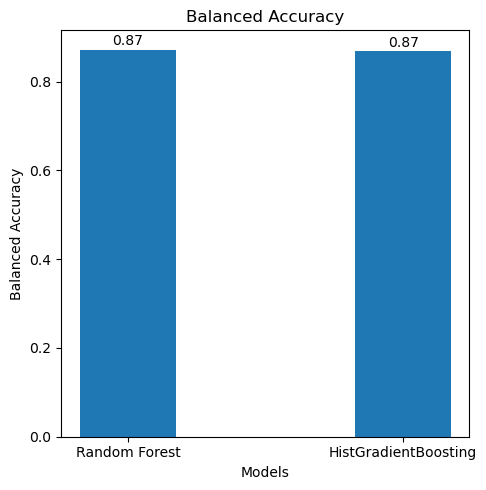

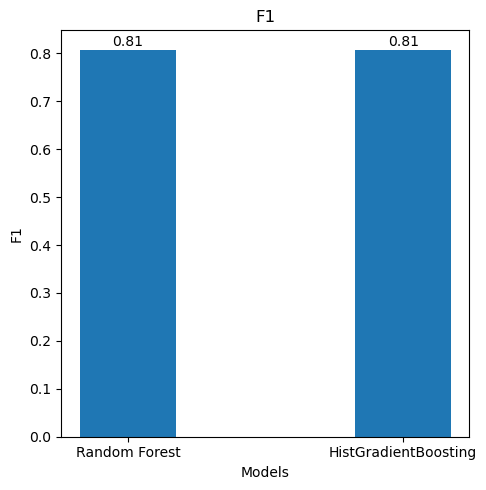

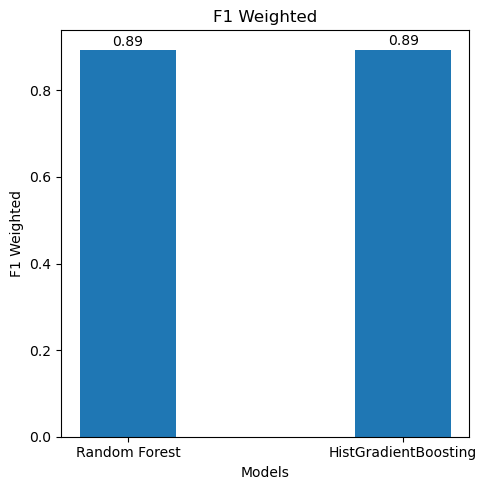

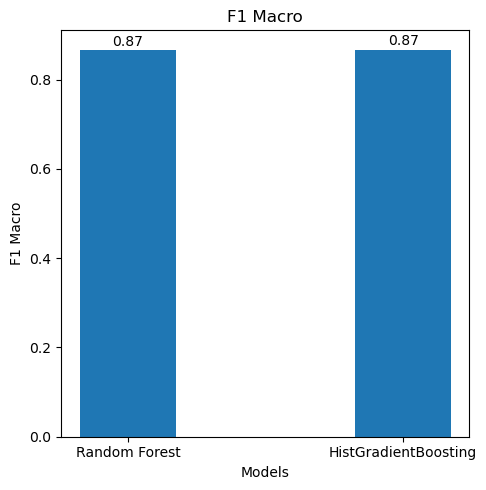

In [ ]:
models = ['Random Forest', 'HistGradientBoosting']

# Metrics for each model
balanced_accuracy = [balanced_acc_rf, balanced_acc_hgb]
f1_default = [f1_default_rf, f1_default_hgb]
f1_weighted = [f1_weighted_rf, f1_weighted_hgb]
f1_macro = [f1_macro_rf, f1_macro_hgb]

# Plot the graphs
plot_metric(balanced_accuracy, 'Balanced Accuracy')
plot_metric(f1_default, 'F1')
plot_metric(f1_weighted, 'F1 Weighted')
plot_metric(f1_macro, 'F1 Macro')

### 5.4.3 LSTM

In [ ]:
# Custom callback to calculate balanced accuracy, weighted F1 score, and macro F1 score
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_balanced_accuracy = balanced_accuracy_score(val_targ, val_predict)
        _val_weighted_f1 = f1_score(val_targ, val_predict, average='weighted')
        _val_macro_f1 = f1_score(val_targ, val_predict, average='macro')
        print(f' — val_balanced_accuracy: {_val_balanced_accuracy} — val_weighted_f1: {_val_weighted_f1} — val_macro_f1: {_val_macro_f1}')
        logs['val_balanced_accuracy'] = _val_balanced_accuracy
        logs['val_weighted_f1'] = _val_weighted_f1
        logs['val_macro_f1'] = _val_macro_f1

In [ ]:
# LSTM model
model = Sequential()

model.add(LSTM(128, input_shape=(combined_features_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=256))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1152, 128)         66560     
                                                                 
 dropout_9 (Dropout)         (None, 1152, 128)         0         
                                                                 
 lstm_10 (LSTM)              (None, 1152, 256)         394240    
                                                                 
 dropout_10 (Dropout)        (None, 1152, 256)         0         
                                                                 
 lstm_11 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
metrics_callback = MetricsCallback(validation_data=(combined_features_test, y_test))

In [ ]:
# Train
history = model.fit(combined_features_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(combined_features_test, y_test),
                    callbacks=[early_stopping, metrics_callback])

Epoch 1/100
40/40 [==============================] - 4s 76ms/step
 — val_balanced_accuracy: 0.5 — val_weighted_f1: 0.6112800741427248 — val_macro_f1: 0.42075996292863765
79/79 [==============================] - 26s 288ms/step - loss: 0.6297 - accuracy: 0.7137 - val_loss: 0.5678 - val_accuracy: 0.7264 - val_balanced_accuracy: 0.5000 - val_weighted_f1: 0.6113 - val_macro_f1: 0.4208
Epoch 2/100
40/40 [==============================] - 3s 74ms/step
 — val_balanced_accuracy: 0.8498273952134374 — val_weighted_f1: 0.8562962882479925 — val_macro_f1: 0.8255152863699711
79/79 [==============================] - 21s 272ms/step - loss: 0.5578 - accuracy: 0.7205 - val_loss: 0.4303 - val_accuracy: 0.8520 - val_balanced_accuracy: 0.8498 - val_weighted_f1: 0.8563 - val_macro_f1: 0.8255
Epoch 3/100
40/40 [==============================] - 3s 74ms/step
 — val_balanced_accuracy: 0.8487260736275344 — val_weighted_f1: 0.8548278962536023 — val_macro_f1: 0.8238872878642332
79/79 [=============================

In [ ]:
loss, accuracy = model.evaluate(combined_features_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

40/40 [==============================] - 3s 83ms/step - loss: 0.3583 - accuracy: 0.8608
Test Loss: 0.35834193229675293
Test Accuracy: 0.86080002784729


In [ ]:
# Predict on the test set
y_test_pred = (model.predict(combined_features_test)).round()

# Predict on the training set
y_train_pred = (model.predict(combined_features_train)).round()

# Calculate metrics for the training set
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
train_f1_weighted = f1_score(y_train, y_train_pred, average="weighted")
train_f1_macro = f1_score(y_train, y_train_pred, average="macro")

# Calculate metrics for the test set
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")

# Print training set metrics
print("\nTraining Set Metrics:")
print("-"*21)
print("Balanced Accuracy:", np.round(train_balanced_acc, 2))
print("Weighted F1 score:", np.round(train_f1_weighted, 2))
print("Macro F1 score:", np.round(train_f1_macro, 2))
print("="*23)

# Print test set metrics
print("Test Set Metrics:")
print("-"*21)
print("Balanced Accuracy:", np.round(test_balanced_acc, 2))
print("Weighted F1 score:", np.round(test_f1_weighted, 2))
print("Macro F1 score:", np.round(test_f1_macro, 2))
print("="*23)
print("Classification Report:\n", classification_report(y_test, y_test_pred))

157/157 [==============================] - 13s 83ms/step

Training Set Metrics:
---------------------
Balanced Accuracy: 0.86
Weighted F1 score: 0.87
Macro F1 score: 0.84
Test Set Metrics:
---------------------
Balanced Accuracy: 0.86
Weighted F1 score: 0.86
Macro F1 score: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       908
           1       0.70      0.85      0.77       342

    accuracy                           0.86      1250
   macro avg       0.82      0.86      0.83      1250
weighted avg       0.87      0.86      0.86      1250



# Prediction on test dataset

For this project, we were provided with a test dataset. Applying the same preprocessing methods and using our trained model, we made the predictions of the listing status of the test properties and exported them into a CSV file to upload to a Kaggle competition.

In [ ]:
# Test datasets
test_df = pd.read_excel("data/test.xlsx")
test_reviews_df = pd.read_excel("data/test_reviews.xlsx")

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        695 non-null    int64 
 1   description  695 non-null    object
 2   host_about   695 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.4+ KB


In [ ]:
reviews_limited = test_reviews_df.groupby("index").apply(lambda group: group.sample(10, random_state=42) if len(group) > 10 else group)
reviews_limited = reviews_limited[["comments"]].reset_index()
reviews_limited = reviews_limited[['index', 'comments']]
# let's merge the dataframe with limited reviews with our train dataframe with listings descriptions and host about
aggregated_comments = reviews_limited.groupby('index').agg({
    'comments': lambda x: 'sep '.join(x)
}).reset_index()

merged_df = pd.merge(test_df, aggregated_comments, on='index',  how='left')

merged_df.head()
merged_df["comments"] = merged_df["comments"].fillna("")

merged_df["comments_clean"] = cleaning_preserving_all_words(merged_df["comments"])
merged_df["description_clean"] = cleaning_preserving_all_words(merged_df["description"])
merged_df["host_about_clean"] = cleaning_preserving_all_words(merged_df["host_about"])
full_df = merged_df[["index","description_clean", "host_about_clean", "comments_clean"]]
test = full_df

100%|█████████████████████████████████████████████████████████████████████████████| 695/695 [00:00<00:00, 19036.76it/s]


In [ ]:
test.head()

,index,description_clean,host_about_clean,comments_clean
0,1,the spaceapartment located in the historic cen...,gosto de viajar de conhecer pessoas gosto de...,das apartment ist gro artig tolle lage und ex...
1,2,important in response to covid this prope...,we are the be home team you can count on us ...,appartement tr s agr able lumineux propre.ri...
2,3,bright beautiful and spacious. this four bed...,hi there we re guestready a professional pr...,
3,4,charming apartment close to the bay of cascais...,,claudia was a great host. she met us at the t...
4,5,se procura umas f rias perto da praia casino ...,bem vindos a portugal adoro o meu pa s mas t...,nous avons pass un tr s bon sejour dans cet a...


In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

comments_test_list = test['comments_clean'].tolist()
comments_embeddings_test = model.encode(comments_test_list).tolist()

comments_embeddings_test = np.array(comments_embeddings_test)
np.save('comments_embeddings_test.npy', comments_embeddings_test)

In [ ]:
test_desc_list = test["description_clean"].tolist()
test_host_list = test["host_about_clean"].tolist()

embeddings_desc_test = model.encode(test_desc_list).tolist()
embeddings_desc_test = np.array(embeddings_desc_test)
np.save('embeddings_desc_test.npy', embeddings_desc_test)

embeddings_host_test = model.encode(test_host_list).tolist()
embeddings_host_test = np.array(embeddings_host_test)
np.save('embeddings_host_test.npy', embeddings_host_test)

In [ ]:
combined_features_test = np.hstack([embeddings_desc_test, embeddings_host_test])
combined_features_test = np.hstack([combined_features_test, comments_embeddings_test])

In [ ]:
desc_embeddings_train = np.load('desc_embeddings_train_XXX.npy')
desc_embeddings_val= np.load('desc_embeddings_test_XXX.npy')

host_embeddings_train_XXX = np.load('host_embeddings_train_XXX.npy')
host_embeddings_val_XXX = np.load('host_embeddings_test_XXX.npy')

combined_features_train = np.hstack([desc_embeddings_train, host_embeddings_train_XXX])
combined_features_train = np.hstack([combined_features_train, comments_embeddings_train_0])

combined_features_val = np.hstack([desc_embeddings_val, host_embeddings_val_XXX])
combined_features_val = np.hstack([combined_features_val, comments_embeddings_test_0])

In [ ]:
hist_best = HistGradientBoostingClassifier(learning_rate=0.09, max_depth=17, random_state=42)
balanced_acc_hgb, f1_default_hgb, f1_weighted_hgb, f1_macro_hgb = train_validate(hist_best, combined_features_train, combined_features_val, y_train, y_test)


Training Set Metrics:
---------------------
Balanced Accuracy: 1.0
Default F1 score: 1.0
Weighted F1 score: 1.0
Macro F1 score: 1.0
Test Set Metrics:
---------------------
Balanced Accuracy: 0.87
Default F1 score: 0.81
Weighted F1 score: 0.89
Macro F1 score: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       908
           1       0.80      0.82      0.81       342

    accuracy                           0.89      1250
   macro avg       0.86      0.87      0.87      1250
weighted avg       0.89      0.89      0.89      1250



In [ ]:
hist_best = HistGradientBoostingClassifier(learning_rate=0.09, max_depth=17, random_state=42).fit(combined_features_train, y_train)
predictions = hist_best.predict(combined_features_test)

index_column = test['index']

# Create a df with 'index' and 'predicted' columns
output_df = pd.DataFrame({
    'index': index_column,
    'predicted': predictions
})

output_df.to_csv('Predictions_06.csv', index=False)

In [ ]:
output_df.head()

,index,predicted
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
